In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.optim import AdamW
import torchvision
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


BATCH_SIZE = 64

main_path = "C:\\Users\\munod\\OneDrive\\Documents\\Datasets\\Tuberculosis_(TB)_Chest_X-ray_Database\\TB_Chest_Radiography_Database"
directories = os.listdir(main_path)
images = []
labels = []
for direct in directories:
    #print(direct)
    path1 = os.path.join(main_path, direct)
    files = os.listdir(path1)
    if direct == "Normal":
        code = 0
    elif direct == "Tuberculosis":
        code = 1
    
    counter = 0
    for file in files:
        img = cv2.imread(os.path.join(path1,file))
        img = cv2.resize(img, (200,200))
        labels.append(code)
        images.append(img)
        counter += 1


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
images = np.asarray(images)
labels = np.asarray(labels)
display("Shape of Images" , images.shape, "Label Shape", labels.shape, counter)

'Shape of Images'

(4200, 200, 200, 3)

'Label Shape'

(4200,)

700

In [4]:
# data = images/255.0

In [5]:
X_train,X_test_combined, y_train, y_test_combined = train_test_split(images, labels, test_size=0.4, shuffle=True)


In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_test_combined, y_test_combined, test_size=0.5, shuffle=True)

In [7]:
class create_dataset(Dataset):
    def __init__(self, x, y=None):
        super().__init__()
        self.x = torch.tensor(x, dtype=torch.uint8).view(-1, 3, 200, 200).float()/255
        self.y = torch.tensor(y, dtype=torch.uint8).view(-1,1).float()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
        

In [8]:
train_data = create_dataset(X_train, y_train)
val_data = create_dataset(X_val, y_val)
test_data = create_dataset(X_test, y_test)

In [9]:
data_load_train = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
data_load_val= DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
data_load_test = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:

class Custom_VGG19_Binary_Classifier(nn.Module):
    def __init__(self):
        super(Custom_VGG19_Binary_Classifier, self).__init__()
        self.base_model = torchvision.models.vgg19(pretrained=True)

        for param in list(self.base_model.parameters())[:-3]:
            param.requires_grad = False
        
        self.base_model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            # nn.Sigmoid()
            # nn.Linear(256,1)
        )
    def forward(self, x):
        x = self.base_model(x)
        return F.sigmoid(x)
        


In [11]:
model = Custom_VGG19_Binary_Classifier()
summary(model, (3, 224,224))

C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\munod\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [12]:
model = model.to(device)

In [13]:
def epoch(model, data_load_train, optimizer, loss_function):
    model.train()
    losses = []
    for X_batch, y_batch in data_load_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        # print(f"Target size {y_batch.size()}. Prediction size {y_pred.size()}")
        loss = loss_function(y_batch, y_pred)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    return np.mean(losses)


def eval(model, data_load_val, loss_function):
    model.eval()
    labels = []
    predictions = []
    losses = []
    f1_scores = []
    accuracy_scores = []
    with torch.no_grad():
        for X_batch, y_batch in data_load_val:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            labels.extend(y_batch.detach().cpu().numpy())

            y_pred = model(X_batch)

            predictions.extend(y_pred.detach().cpu().numpy())

            losses.append(loss_function(y_batch, y_pred).detach().cpu().numpy())
            f1_scores.append(f1_score(y_batch.detach().cpu().numpy(), y_pred.argmax(dim=1).cpu().detach().numpy(), average="macro"))
            accuracy_scores.append(accuracy_score(y_batch.detach().cpu().numpy(), y_pred.argmax(dim=1).cpu().detach().numpy()))
    return {"loss":np.mean(losses), "f1":np.mean(f1_scores), 'accuracy':np.mean(accuracy_scores)}

def fit(model, data_load_train, data_load_val, epochs, learning_rate, patience):
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    history = []

    best_loss = np.inf
    patience_count = 0


    for i in range(epochs):
        train_loss = epoch(model, data_load_train, optimizer, loss_function)
        eval_metrics = eval(model, data_load_val, loss_function)
        history.append({
            "train_loss":train_loss,
            "valid_loss":eval_metrics['loss'],
            "f1":eval_metrics['f1'],
            "accuracy":eval_metrics['accuracy']
        }
        )
        print(f"Epoch {i+1}/{epochs}. The training loss: {train_loss}. The validation loss: {eval_metrics['loss']}. The F1 Score: {eval_metrics['f1']} ")

        if eval_metrics['loss'] < best_loss:
            best_loss = eval_metrics['loss']
            patience_count = 0
            best_model_state = model.state_dict()
        else:
            patience_count += 1
            if patience_count > patience:
                break
    
    model.load_state_dict(best_model_state)
    return pd.DataFrame(history)




In [14]:
history = fit(model, data_load_train, data_load_val, 10, 0.001, 3)

Epoch 1/10. The training loss: 0.0. The validation loss: 0.0. The F1 Score: 0.4574064838761634 


KeyboardInterrupt: 

In [ ]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

In [ ]:
plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()


AttributeError: 'Custom_VGG19_Binary_Classifier' object has no attribute 'history'

In [ ]:
plt.plot(model.history.history['binary_accuracy'], label='accuracy')
plt.plot(model.history.history['val_binary_accuracy'], label='Val accuracy')
plt.legend()
plt.show()

AttributeError: 'Custom_VGG19_Binary_Classifier' object has no attribute 'history'

In [ ]:
result = model.evaluate(X_test, y_test, batch_size=32)


print(f'The accuracy is {result[1]}')
print(f'The loss is {result[0]}')

AttributeError: 'Custom_VGG19_Binary_Classifier' object has no attribute 'evaluate'

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc


y_pred = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step


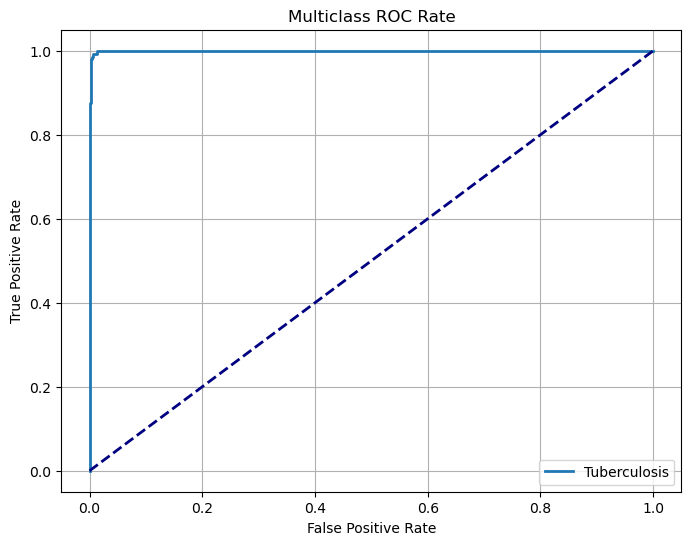

AUROC for class Tuberculosis : 1.000


In [ ]:
y_true = y_test
n_classes = 2
fpr = {}
tpr = {}
# roc_auc = {}
classes_names = {0:"Normal", 1:"Tuberculosis"}
classes_names_list = ["Tuberculosis"]


fpr, tpr,  _ =  roc_curve(y_true, y_pred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(8,6))

plt.plot(
    fpr, tpr, 
    lw=2,
    label=f"Class {1} (area = {roc_auc:.3f})"
)

plt.plot([0,1], [0,1], color="navy", lw=2, linestyle= "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Rate")
plt.legend(classes_names_list, loc="lower right")
plt.grid()
plt.show()


print(f"AUROC for class {classes_names[1]} : {roc_auc:.3f}")


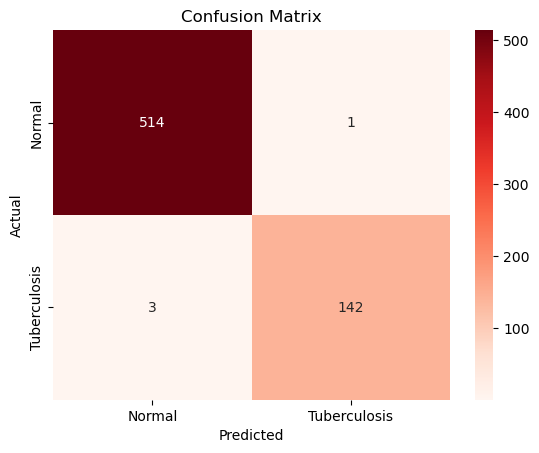

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=np.round(y_pred))

sns.heatmap(cm, cmap="Reds", 
            annot=True, 
            fmt='g',
            xticklabels=["Normal","Tuberculosis"],
            yticklabels=["Normal","Tuberculosis"],
            )

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(f"Sensitivity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[1][0]):.3f}")
print(f"Specificity to correctly classifiy a CXR with TB {cm[1][1]/(cm[1][1]+cm[0][1]):.3f}")

Sensitivity to correctly classifiy a CXR with TB 0.979
Specificity to correctly classifiy a CXR with TB 0.993


In [ ]:

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,872,005 (110.14 MB)

 Trainable params: 4,719,105 (18.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 9,438,212 (36.00 MB)

In [ ]:
model.save("cxr_normal_tb_vgg16_model.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("cxr_normal_tb_vgg16_model.keras")